In [ ]:
# api token upload
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shifamehreen","key":"8b94ce850d6d49c566ad1e21d062cd71"}'}

In [ ]:
# load dataset form kaggle
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!kaggle datasets download -d andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k.zip
!mkdir ODIR-5K/Validation_Images

Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow
from tensorflow import keras
from keras_preprocessing.image import ImageDataGenerator


In [ ]:
df = pd.read_csv("/content/full_df.csv")
df.sample(5)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
2812,4245,56,Male,4245_left.jpg,4245_right.jpg,normal fundus,mild nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4245_right.jpg
1364,2065,58,Male,2065_left.jpg,2065_right.jpg,dry age-related macular degeneration,myelinated nerve fibers,0,0,0,0,1,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",2065_right.jpg
5969,4204,47,Female,4204_left.jpg,4204_right.jpg,severe nonproliferative retinopathy,severe nonproliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4204_left.jpg
5328,3007,59,Female,3007_left.jpg,3007_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",3007_left.jpg
5245,2918,75,Male,2918_left.jpg,2918_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",2918_left.jpg


In [ ]:
def has_amd(text):
    if "macular degeneration" in text:
        return 1
    else:
        return 0

In [ ]:
df["left_amd"] = df["Left-Diagnostic Keywords"].apply(lambda x: has_amd(x))
df["right_amd"] = df["Right-Diagnostic Keywords"].apply(lambda x: has_amd(x))

In [ ]:
left_amd = df.loc[(df.A ==1) & (df.left_amd == 1)]["Left-Fundus"].values
left_amd[:15]

array(['43_left.jpg', '48_left.jpg', '53_left.jpg', '55_left.jpg',
       '102_left.jpg', '126_left.jpg', '136_left.jpg', '152_left.jpg',
       '158_left.jpg', '162_left.jpg', '164_left.jpg', '168_left.jpg',
       '178_left.jpg', '210_left.jpg', '212_left.jpg'], dtype=object)

In [ ]:
right_amd = df.loc[(df.A ==1) & (df.right_amd == 1)]["Right-Fundus"].values
right_amd[:15]

array(['43_right.jpg', '48_right.jpg', '53_right.jpg', '55_right.jpg',
       '71_right.jpg', '102_right.jpg', '126_right.jpg', '152_right.jpg',
       '153_right.jpg', '158_right.jpg', '160_right.jpg', '162_right.jpg',
       '164_right.jpg', '168_right.jpg', '178_right.jpg'], dtype=object)

In [ ]:
print("Number of images in left amd: {}".format(len(left_amd)))
print("Number of images in right amd: {}".format(len(right_amd)))

Number of images in left amd: 266
Number of images in right amd: 285


In [ ]:
left_normal = df.loc[(df.A ==0) & (df["Left-Diagnostic Keywords"] == "normal fundus")]["Left-Fundus"].sample(250,random_state=42).values
right_normal = df.loc[(df.A ==0) & (df["Right-Diagnostic Keywords"] == "normal fundus")]["Right-Fundus"].sample(250,random_state=42).values
right_normal[:15]

array(['2760_right.jpg', '2981_right.jpg', '2425_right.jpg',
       '3250_right.jpg', '2505_right.jpg', '939_right.jpg',
       '2714_right.jpg', '205_right.jpg', '215_right.jpg',
       '3429_right.jpg', '2488_right.jpg', '909_right.jpg',
       '2336_right.jpg', '2974_right.jpg', '875_right.jpg'], dtype=object)

In [ ]:
amd = np.concatenate((left_amd,right_amd),axis=0)
normal = np.concatenate((left_normal,right_normal),axis=0)

In [ ]:
print(len(amd),len(normal))

551 500


In [ ]:
from keras_preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images"
image_size=224
labels = []
dataset = []
def create_dataset(image_category,label):
    for img in tqdm(image_category):
        image_path = os.path.join(dataset_dir,img)
        try:
            image = cv2.imread(image_path,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue

        dataset.append([np.array(image),np.array(label)])
    random.shuffle(dataset)
    return dataset


In [ ]:
dataset = create_dataset(amd,1)

100%|██████████| 551/551 [00:02<00:00, 234.81it/s]


In [ ]:
len(dataset)

551

In [ ]:
dataset = create_dataset(normal,0)

100%|██████████| 500/500 [00:02<00:00, 245.54it/s]


In [ ]:
len(dataset)

1051

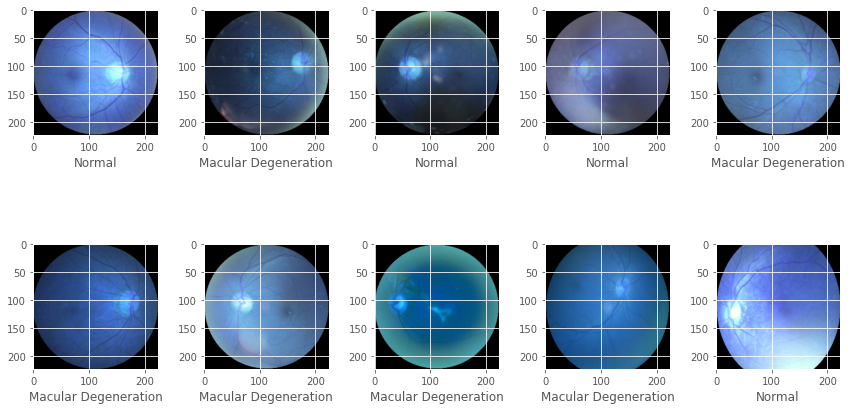

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset)))
    image = dataset[sample][0]
    category = dataset[sample][1]
    if category== 0:
        label = "Normal"
    else:
        label = "Macular Degeneration"
    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
x = np.array([i[0] for i in dataset]).reshape(-1,image_size,image_size,3)
y = np.array([i[1] for i in dataset])

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2)

MODEL

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19
vgg = VGG19(weights="imagenet",include_top = False,input_shape=(image_size,image_size,3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense
model = Sequential()
model.add(vgg)
model.add(Flatten())
model.add(Dense(1,activation="sigmoid"))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1)                 25089     
                                                                 
Total params: 20,049,473
Trainable params: 25,089
Non-trainable params: 20,024,384
_________________________________________________________________


In [ ]:
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=["accuracy"])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
checkpoint = ModelCheckpoint("vgg19.h5",monitor="val_acc",verbose=1,save_best_only=True,
                             save_weights_only=False,period=1)
earlystop = EarlyStopping(monitor="val_acc",patience=5,verbose=1)

In [ ]:
history = model.fit(x_train,y_train,batch_size=32,epochs=15,validation_data=(x_test,y_test),
                    verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/15
27/27 [==============================] - ETA: 0s - loss: 3.5446 - accuracy: 0.6286

27/27 [==============================] - 21s 318ms/step - loss: 3.5446 - accuracy: 0.6286 - val_loss: 2.0688 - val_accuracy: 0.7014
Epoch 2/15
27/27 [==============================] - ETA: 0s - loss: 0.6105 - accuracy: 0.8667

27/27 [==============================] - 6s 209ms/step - loss: 0.6105 - accuracy: 0.8667 - val_loss: 1.2250 - val_accuracy: 0.7820
Epoch 3/15
27/27 [==============================] - ETA: 0s - loss: 0.4578 - accuracy: 0.9060

27/27 [==============================] - 6s 211ms/step - loss: 0.4578 - accuracy: 0.9060 - val_loss: 1.3796 - val_accuracy: 0.7915
Epoch 4/15
27/27 [==============================] - ETA: 0s - loss: 0.1625 - accuracy: 0.9512

27/27 [==============================] - 6s 212ms/step - loss: 0.1625 - accuracy: 0.9512 - val_loss: 0.8698 - val_accuracy: 0.8104
Epoch 5/15
27/27 [==============================] - ETA: 0s - loss: 0.0594 - accuracy: 0.9798

27/27 [==============================] - 6s 213ms/step - loss: 0.0594 - accuracy: 0.9798 - val_loss: 0.7635 - val_accuracy: 0.8483
Epoch 6/15
27/27 [==============================] - ETA: 0s - loss: 0.0133 - accuracy: 0.9940

27/27 [==============================] - 6s 214ms/step - loss: 0.0133 - accuracy: 0.9940 - val_loss: 0.6450 - val_accuracy: 0.8815
Epoch 7/15
27/27 [==============================] - ETA: 0s - loss: 0.0046 - accuracy: 0.9988

27/27 [==============================] - 6s 215ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 0.7195 - val_accuracy: 0.8531
Epoch 8/15
27/27 [==============================] - ETA: 0s - loss: 0.0018 - accuracy: 1.0000

27/27 [==============================] - 6s 218ms/step - loss: 0.0018 - accuracy: 1.0000 - val_loss: 0.6708 - val_accuracy: 0.8720
Epoch 9/15
27/27 [==============================] - ETA: 0s - loss: 5.8334e-04 - accuracy: 1.0000

27/27 [==============================] - 6s 221ms/step - loss: 5.8334e-04 - accuracy: 1.0000 - val_loss: 0.6609 - val_accuracy: 0.8720
Epoch 10/15
27/27 [==============================] - ETA: 0s - loss: 4.8866e-04 - accuracy: 1.0000

27/27 [==============================] - 6s 222ms/step - loss: 4.8866e-04 - accuracy: 1.0000 - val_loss: 0.6503 - val_accuracy: 0.8768
Epoch 11/15
27/27 [==============================] - ETA: 0s - loss: 4.3632e-04 - accuracy: 1.0000

27/27 [==============================] - 6s 223ms/step - loss: 4.3632e-04 - accuracy: 1.0000 - val_loss: 0.6530 - val_accuracy: 0.8768
Epoch 12/15
27/27 [==============================] - ETA: 0s - loss: 3.9362e-04 - accuracy: 1.0000

27/27 [==============================] - 6s 226ms/step - loss: 3.9362e-04 - accuracy: 1.0000 - val_loss: 0.6525 - val_accuracy: 0.8768
Epoch 13/15
27/27 [==============================] - ETA: 0s - loss: 3.6483e-04 - accuracy: 1.0000

27/27 [==============================] - 6s 226ms/step - loss: 3.6483e-04 - accuracy: 1.0000 - val_loss: 0.6509 - val_accuracy: 0.8720
Epoch 14/15
27/27 [==============================] - ETA: 0s - loss: 3.4192e-04 - accuracy: 1.0000

27/27 [==============================] - 6s 227ms/step - loss: 3.4192e-04 - accuracy: 1.0000 - val_loss: 0.6488 - val_accuracy: 0.8720
Epoch 15/15
27/27 [==============================] - ETA: 0s - loss: 3.1816e-04 - accuracy: 1.0000

27/27 [==============================] - 6s 229ms/step - loss: 3.1816e-04 - accuracy: 1.0000 - val_loss: 0.6450 - val_accuracy: 0.8720


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test)
print("loss:",loss)
print("Accuracy:",accuracy)

7/7 [==============================] - 1s 172ms/step - loss: 0.6450 - accuracy: 0.8720
loss: 0.6449716687202454
Accuracy: 0.8720378875732422


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = (model.predict(x_test) > 0.5).astype("int32")


7/7 [==============================] - 1s 177ms/step


In [ ]:
accuracy_score(y_test,y_pred)

0.8720379146919431

In [ ]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.91      0.80      0.85        96
           1       0.85      0.93      0.89       115

    accuracy                           0.87       211
   macro avg       0.88      0.87      0.87       211
weighted avg       0.87      0.87      0.87       211



Text(33.0, 0.5, 'Actual')

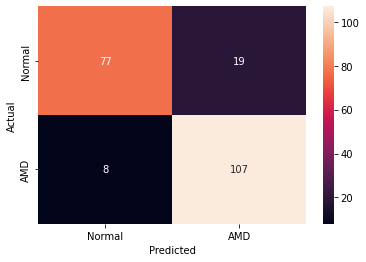

In [ ]:
import tensorflow as tf
cm = tf.math.confusion_matrix(labels=y_test, predictions=y_pred)

import seaborn as sns
x_labels = ["Normal", "AMD"]
y_labels = ["Normal", "AMD"]
sns.heatmap(cm, annot=True, fmt='g', xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")



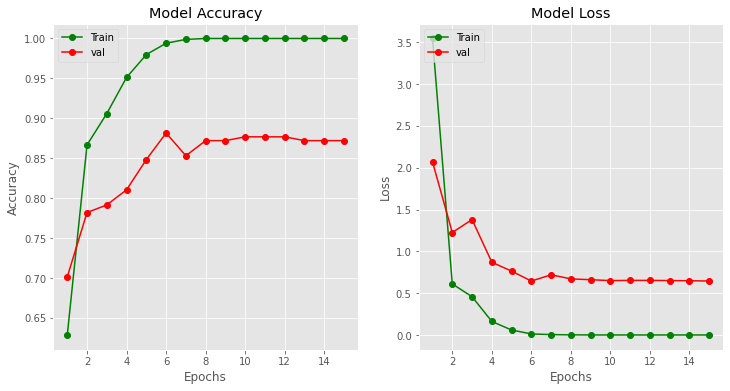

In [ ]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(12,6))
epochs = range(1,16)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","val"],loc = "upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","val"],loc = "upper left")
plt.show()






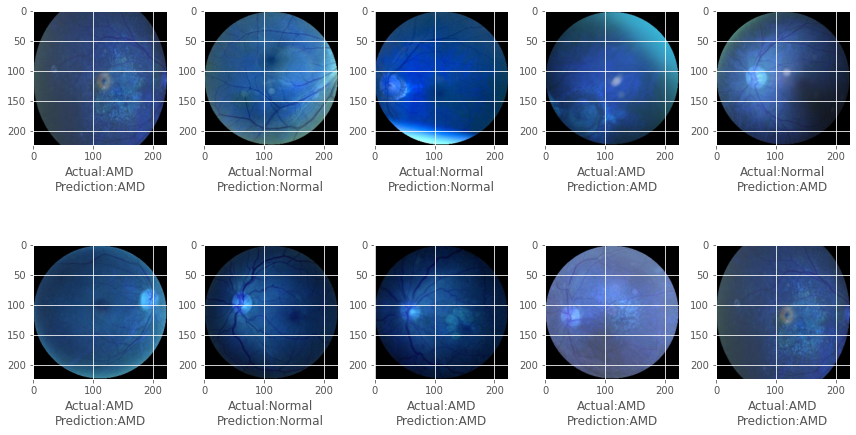

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    else:
        label = "AMD"

    if pred_category== 0:
        pred_label = "Normal"
    else:
        pred_label = "AMD"

    plt.subplot(2,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()